In [1]:
import h5py
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
import scipy.misc
import scipy.io
import random

In [2]:
#-----------------------------------------------------------------
# train
train_images = []
tlabels = []

# train Image 데이터 700장을 불러온다
# train Label 데이터를 불러온다
with h5py.File('kalph_train.hf', 'r') as hf:
    train_images = np.array(hf['images'])
    tlabels = np.array(hf['labels'])


# Image 데이터와 Label 데이터를 numpy 데이터로 수정한다
train_images = train_images.reshape(19600, 2704, )


# train Label 데이터를 [1 x 100] 의 행렬로 표현한다
#           예를 들어 3이면 [0,0,1,0,.....,0] 과 같이 설정한다
train_labels  = np.array(np.zeros(274400).reshape(19600,14))
for num in range(0,19600):
    train_labels[num][int(tlabels[num]) - 1] = 1



#-----------------------------------------------------------------
# test
test_images = []
testlabels = []


# train Image 데이터 700장을 불러온다
# train Label 데이터를 불러온다
with h5py.File('kalph_test.hf', 'r') as hf:
    test_images = np.array(hf['images'])
    testlabels = np.array(hf['labels'])



# Image 데이터와 Label 데이터를 numpy 데이터로 수정한다
test_images = test_images.reshape(3920, 2704, )

# train Label 데이터를 [1 x 100] 의 행렬로 표현한다
#           예를 들어 3이면 [0,0,1,0,.....,0] 과 같이 설정한다
test_labels  = np.array(np.zeros(58440).reshape(3920,14))
for num in range(0,3920):
    test_labels[num][int(testlabels[num]) - 1] = 1


# 중요! Image 데이터들은 0~255 사이의 값이므로 255로 나눠주면서 정규화를 한다. 학습이 매우 잘된다
train_images = train_images / 255.
test_images =  test_images / 255.


In [3]:
#-----------------------------------------------------------------

_num_examples, bins = train_images.shape
# _num_examples : 데이터 갯수

_index_in_epoch = 0   # epoch
_images = train_images  # Image 변수 
_labels = train_labels  # Label 변수
_epochs_completed = 0   

# batch 연산을 수행하는 함수
# 호출될 때마다 랜덤으로 batch_size의 (Image, Label) 데이터를 반환한다
def next_batch(batch_size):
    """Return the next `batch_size` examples from this data set."""
    global _index_in_epoch
    global _images
    global _labels
    global _epochs_completed

    start = _index_in_epoch
    _index_in_epoch += batch_size

    if _index_in_epoch > _num_examples:
      # Finished epoch
      _epochs_completed += 1

      # Shuffle the data
      perm = np.arange(_num_examples)
      np.random.shuffle(perm)
      _images = _images[perm]
      _labels = _labels[perm]

      # Start next epoch
      start = 0
      _index_in_epoch = batch_size
      assert batch_size <= _num_examples

    end = _index_in_epoch
    return _images[start:end], _labels[start:end]


# 가중치를 초기화하는 함수 (정규분포 stddev=0.1로 초기화한다)
def weight_variable(shape):
	initial = tf.truncated_normal(shape, stddev=0.1)
	return tf.Variable(initial)


# 바이어스를 초기화하는 함수 (0.1로 초기화한다)
def bias_variable(shape):
	initial = tf.constant(0.1, shape=shape)
	return tf.Variable(initial)




In [4]:
#-----------------------------------------------------------------
# Tensorflow 코드
#-----------------------------------------------------------------

# None 은 내가 얼만큼의 데이터를 넣을지 안 정했을 때 사용한다
x_input = tf.placeholder(tf.float32, [None, 2704])
y_input = tf.placeholder(tf.float32, [None, 14])

# 신경망 파라미터들 y = x*w + b
W = tf.Variable(tf.zeros([2704, 14]))
b = tf.Variable(tf.zeros([14]))
y = tf.matmul(x_input , W ) + b


# softmax 알고리즘을 실행해서 y값을 최적화하고 cross_entropy를 정의한다
# softmax : 값을 0 ~ 1사이로 정규화시키는 함수 (총합은 1이 되도록 정규화하므로 확률로 변경하는 것과 같다)
y = tf.nn.softmax(y)
cross_entropy = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(labels=y_input, logits=y))

# Gradient Descent 알고리즘을 사용해서 cross_entropy를 최소화한다. 학습율은 0.5
train_step = tf.train.GradientDescentOptimizer(0.5).minimize(cross_entropy)



# 세션을 초기화한다
sess = tf.InteractiveSession()
sess.run(tf.global_variables_initializer())


# 정답률을 계산한다  y_conv  vs  y
correct_prediction = tf.equal(tf.argmax(y_input, 1), tf.argmax(y, 1))
accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))




In [44]:
#----------------------------------------------
batch_size = 50      # 한 루프에 몇개의 (Image, Label) 데이터를 학습하는지 설정
display_step = 200    # 루프를 돌면서 화면에 표시할 빈도 설정

for i in range(10000):
	costVal = 0.
	batch = next_batch(batch_size)
    
	# 200번 돌릴 때마다 결과를 확인한다
	if i % display_step == 0:
		train_accuracy = sess.run(accuracy,feed_dict={x:batch[0], y:batch[1], keep_prob:1.0})
		costVal = sess.run(cross_entropy, feed_dict={x: batch[0], y: batch[1], keep_prob:1.0})
    
		print('step', i , 'training_accuracy', train_accuracy,'cost', costVal)
        
        # 실제 학습과정 함수, dropout 50%를 토대로 학습한다
        
        
	sess.run(train_step,feed_dict={x:batch[0],y:batch[1], keep_prob:0.5})





step 0 training_accuracy 0.98 cost 0.0527314
step 200 training_accuracy 1.0 cost 0.0291989
step 400 training_accuracy 0.98 cost 0.0366447
step 600 training_accuracy 1.0 cost 0.039706
step 800 training_accuracy 0.98 cost 0.0744977
step 1000 training_accuracy 1.0 cost 0.00642066
step 1200 training_accuracy 1.0 cost 0.0144326
step 1400 training_accuracy 1.0 cost 0.0120197
step 1600 training_accuracy 0.98 cost 0.0291981
step 1800 training_accuracy 1.0 cost 0.0133996
step 2000 training_accuracy 1.0 cost 0.0152825
step 2200 training_accuracy 1.0 cost 0.005904
step 2400 training_accuracy 1.0 cost 0.0132553
step 2600 training_accuracy 1.0 cost 0.0227472
step 2800 training_accuracy 1.0 cost 0.00524781
step 3000 training_accuracy 1.0 cost 0.0154982
step 3200 training_accuracy 1.0 cost 0.00565141
step 3400 training_accuracy 1.0 cost 0.00427606
step 3600 training_accuracy 1.0 cost 0.0244521
step 3800 training_accuracy 1.0 cost 0.0160789
step 4000 training_accuracy 1.0 cost 0.00113297
step 4200 tra

In [45]:
# 전부 학습이 끝나면 테스트 데이터를 넣어 정확도를 계산한다
test_accuracy = sess.run(accuracy,feed_dict={x: test_images, y: test_labels, keep_prob: 1.0})
print('test accuracy', test_accuracy)

test accuracy 0.765561


In [56]:
# 학습된 가중치들을 저장한다
saver = tf.train.Saver()
save_path = saver.save(sess,'./hangeul1')
print('save_path', save_path)

save_path ./hangeul1.pd


Label:  [12]
Prediction:  [12]


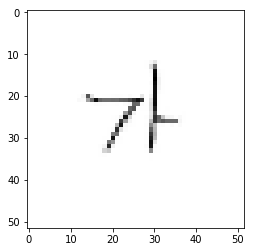

In [54]:
#----------------------------------------------
# 임의의 얼굴 하나를 출력한 다음 맞혀보는 코드 
test_num_examples , bin2 = test_images.shape
r = random.randint(0, test_num_examples -1)
print ("Label: ", sess.run(tf.argmax(test_labels[r:r+1], 1)))
print ("Prediction: ", sess.run(tf.argmax(y_conv, 1), {x:test_images[r:r+1], keep_prob:1.0}))

plt.imshow(test_images[r:r+1].reshape(52, 52), cmap='gray_r', interpolation='nearest')
plt.show()

